In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    
    processed_features = selected_features.copy()
    
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])
    return processed_features

In [3]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = california_housing_dataframe["median_house_value"]/1000
    return output_targets

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2626.5,538.1,1423.7,499.5,3.9,2.0
std,2.1,2.0,12.6,2125.1,413.7,1077.8,374.9,1.9,1.3
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1472.0,299.0,796.0,284.0,2.6,1.5
50%,34.2,-118.5,29.0,2136.0,435.0,1173.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3143.2,648.0,1722.0,606.0,4.7,2.3
max,42.0,-114.3,52.0,30405.0,4957.0,15037.0,4616.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2684.8,542.7,1443.8,505.3,3.9,2.0
std,2.1,2.0,12.6,2306.0,439.8,1300.6,406.8,2.0,0.9
min,32.6,-124.3,1.0,18.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1439.8,290.8,771.0,275.0,2.6,1.5
50%,34.2,-118.5,29.0,2111.5,431.0,1152.5,406.0,3.6,2.0
75%,37.7,-118.0,37.0,3173.0,650.0,1718.2,605.0,4.9,2.3
max,41.9,-114.6,52.0,37937.0,6445.0,35682.0,6082.0,15.0,22.6


Training targets summary:


,median_house_value
count,12000.0
mean,205.6
std,115.4
min,15.0
25%,118.6
50%,178.1
75%,262.5
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,211.4
std,117.3
min,15.0
25%,122.5
50%,184.6
75%,271.7
max,500.0


In [5]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["targets"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,targets
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.1
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
targets,-0.1,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


In [6]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")


    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

In [12]:
minimal_features = ["median_income","rooms_per_person"]

assert minimal_features, "Must have at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]



Training model...
RMSE (on training data):
  period 00 : 202.74
  period 01 : 171.31
  period 02 : 141.18
  period 03 : 114.50
  period 04 : 94.40
  period 05 : 89.84
  period 06 : 85.35
  period 07 : 85.71
  period 08 : 84.91
  period 09 : 85.73
Model training finished.


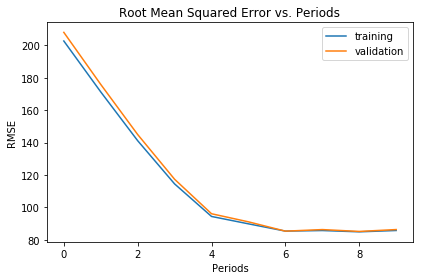

In [16]:
train_model(
    learning_rate = .5,
    steps = 30,
    batch_size = 2,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

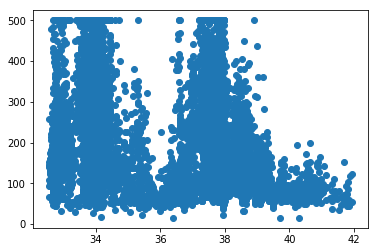

In [19]:
plt.scatter(training_examples["latitude"],training_targets["median_house_value"])

In [21]:
def select_and_transform_features(source_df, minimal_features):
#     selected_examples = pd.DataFrame()
    #add minimal features already selected
#     selected_examples["median_income"] = source_df["median_income"]
    selected_examples = source_df[minimal_features]
#     selected_examples[]
    LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
    for r in LATITUDE_RANGES:
        selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
          lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
    
    LONGITUDE_RANGES = zip(range(-125, -115), range(-124, -114))
    for r in LONGITUDE_RANGES:
        selected_examples["longitude_%d_to_%d" % r] = source_df["longitude"].apply(
          lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
    return selected_examples

In [22]:
minimal_features = ["rooms_per_person","median_income"]
selected_training_examples = select_and_transform_features(training_examples,minimal_features)
selected_validation_examples = select_and_transform_features(validation_examples,minimal_features)

selected_training_examples.describe()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,rooms_per_person,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,...,longitude_-125_to_-124,longitude_-124_to_-123,longitude_-123_to_-122,longitude_-122_to_-121,longitude_-121_to_-120,longitude_-120_to_-119,longitude_-119_to_-118,longitude_-118_to_-117,longitude_-117_to_-116,longitude_-116_to_-115
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,...,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,2.0,3.9,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,...,0.0,0.0,0.2,0.2,0.1,0.1,0.3,0.2,0.0,0.0
std,1.3,1.9,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,...,0.1,0.1,0.4,0.4,0.2,0.3,0.5,0.4,0.2,0.1
min,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.5,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.9,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,2.3,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
max,55.2,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Training model...
RMSE (on training data):
  period 00 : 202.66
  period 01 : 171.39
  period 02 : 143.02
  period 03 : 116.27
  period 04 : 95.78
  period 05 : 101.76
  period 06 : 107.61
  period 07 : 98.54
  period 08 : 95.63
  period 09 : 90.69
Model training finished.


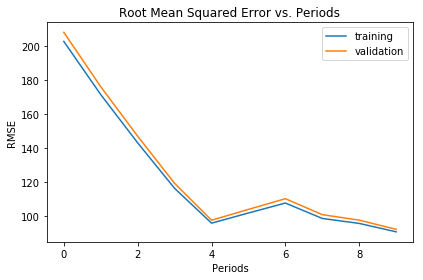

In [24]:
train_model(
    learning_rate = .5,
    steps = 30,
    batch_size = 2,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)